In [142]:
import re 
import cftime 
import nc_time_axis
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.lines import Line2D

from scipy import signal, stats

from scipy.signal import cheby1, filtfilt

import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.gridspec import GridSpec

from shapely import geometry
from src import nino34, precip, utils

import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
                                
import cmaps 
from datetime import datetime

import gcgridobj 

from concurrent.futures import ProcessPoolExecutor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# DEFINE DIRECTORIES HERE
ERSST_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/ERSST/"
HADIS_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/HadISST/"
COBES_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/COBE_SST2/"

GPCC_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/GPCC/full_v2020/"
CRUT_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/CRU_TS4.06/"
APHR_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/APHRODITE/"

In [63]:
# Open global SST datasets

sst_anm_E = utils.get_ds(
    f'{ERSST_DIR}/sst.mnmean.v5.nc'
)

sst_anm_H = utils.get_ds(
    f'{HADIS_DIR}/HadISST_sst.nc'
)

sst_anm_C = utils.get_ds(
    f'{COBES_DIR}/sst.mon.mean.nc'
)

# Calculate TTP using longer timeseries first to minimize tail edge effects
sst_anm_E = sst_anm_E['sst'].sel(time=slice("1938-01", "2019-12"))
sst_anm_H = sst_anm_H['sst'].sel(time=slice("1938-01", "2019-12"))
sst_anm_C = sst_anm_C['sst'].sel(time=slice("1938-01", "2019-12"))

In [225]:
# Functions to calculate tropical interbasin interaction index

def _get_interbasin_areas_modified(da: xr.DataArray):
    """IO = wIOD area, IP = eIOD area, WP = nino3 area 

    """

    utils.check_data_conventions(da)

    # wIOD region
    area1 = da.sel(lat=slice(-10, 10), lon=slice(50, 70))

    # original MC region
    area2 = da.sel(lat=slice(-20, 20), lon=slice(100, 125))

    # Nino4 region
    area3 = da.sel(lat=slice(-5, 5), lon=slice(160, 210)) #160°E–150°W

    return area1, area2, area3


def _apply_interbasin_formula(SSTA_area1, SSTA_area2, SSTA_area3):
    """Calculate the unfiltered interbasin index from SST anomalies in each of
    the three interbasin regions using the interbasin formula.

    Args:

        # tropial west Indian Ocean: 40–80°E, -5°S–5°N)
        SSTA_area1 (xr.DataArray): SSTAs in region 1 (5°S-5°N, 40°E-80°E)
        
        # Central: 100–125°E, -20°S–20°N)
        SSTA_area2 (xr.DataArray): SSTAs in region 2 (20°S-20°N, 100°E-125°E)
        
        #Western Pacific: 5S-5N and 140E-180W
        SSTA_area3 (xr.DataArray): SSTAs in region 3 (5°S-5°N, 140°E-180°E)

    Returns:
        TPI_idx: SSTA_area2 - ((SSTA_area1 + SST_Aarea3)/2)

    """

    a1a3 = SSTA_area1+SSTA_area3
    div2 = a1a3/2.0
    unfilt_interbasin_idx = div2-SSTA_area2

    return unfilt_interbasin_idx


def _apply_cheby1_filter(da: xr.DataArray, period=13*1, btype='lowpass', n=6.0,
                        rp=0.1, fs=None):
    """Apply a Chebyshev type I digital filter to monthly timeseries data.

    Default filter design values are from Henley et al. 2015 (i.e. 13-year
    low-pass filter with period 6 for the TPI Index).

    This function was originally copied from Sonya Wellby's github repo:
    https://github.com/sonyawellby/anu_honours/blob/master/tpi.py
    but I think her comments on the default filter parameters are wrong
    (rp is not 13 and wn is not 0.1).

    Args:
        da (xr.DataArray): monthly timeseries data to be filtered
        period (float, default: 13*12): period of the filter in months
        n (float, default: 6): the order of the filter,
        rp (float, default: 0.1): the peak to peak passband ripple (in decibles)
        fs (bool, default: False): the sampling frequency of the system
                             default = False

    Returns:
        da_filt (xr.DataArray): filtered monthly timeseries data

    """

    wn = 1/(period*0.5)    # critical frequencies --> half-cycles / sample
    b, a = signal.cheby1(n, rp, wn, btype=btype, analog=False,
                         output='ba', fs=fs)
    
    # Convert numpy.ndarray 'nda_filt' to an xr.DataArray
    if 'ensemble' in da.dims:
        nda_filt = signal.filtfilt(b, a, da.values, axis=1)  # output is a filtered numpy.ndarray
        da_filt = xr.DataArray(nda_filt, dims=('ensemble', 'time'), coords={'time': da.coords['time']})
    else:
        nda_filt = signal.filtfilt(b, a, da.values, axis=0)  # output is a filtered numpy.ndarray
        da_filt = xr.DataArray(nda_filt, dims=('time'), coords={'time': da.coords['time']})

    return da_filt


def get_interbasin_timeseries_modified(sst_da: xr.DataArray, detrend: bool,
                          base_start: str, base_end: str,
                          filtered=True):

    """Get the timeseries of the TPI index from SST data.

    Note that the climatological period is the entire time period spanned by
    the input sst data. Must specify option to remove the linear trend.
    Default filtering is a 13-year low pass Chebyshev filter.

    Args:
        sst_da (xr.DataArray): monthly SST data array
        linear_detrend (bool, default: True): if True, remove linear trend
        filtered (bool, default: True): if True, apply 13-year lowpass filter

    Returns:
        interbasin_idx (xr.DataArray): timeseries of the interbasin index in units of
        temperature

    """

    # Detrend the data (optional)
    if detrend:

        # Detrend by removing timeseries of global mean SSTs
        global_mean_ssts = utils.calc_cos_wmean(sst_da)
        sst_da = sst_da-global_mean_ssts

        # Detrend by removing linear trend (does not work for IOB)
        # sst_da = utils.detrend_array(sst_da, "time", 1)

    # Calculate SST anomalies by removing monthly climatology
    # (default climatological period is the entire data period)
    da_anm = utils.remove_monthly_clm(sst_da, base_start, base_end)

    # Get slice of SST anomalies for each interbasin region
    anm1, anm2, anm3 = _get_interbasin_areas_modified(da_anm)

    # Take area-weighted averaged of each region
    mean1 = utils.calc_cos_wmean(anm1)
    mean2 = utils.calc_cos_wmean(anm2)
    mean3 = utils.calc_cos_wmean(anm3)

    # Calculate interbasin index
    interbasin_idx = _apply_interbasin_formula(mean1, mean2, mean3)
    
    # Apply 13-year Chebyshev filter (optional)
    if filtered is True:
        #interbasin_idx = interbasin_idx.rolling(time=13, center=True).mean()
        #mean1 = mean1.rolling(time=13, center=True).mean()
        #mean2 = mean2.rolling(time=13, center=True).mean()
        #mean3 = mean3.rolling(time=13, center=True).mean()

        interbasin_idx = _apply_cheby1_filter(interbasin_idx)
        mean1 = _apply_cheby1_filter(mean1)
        mean2 = _apply_cheby1_filter(mean2)
        mean3 = _apply_cheby1_filter(mean3)



    return interbasin_idx, mean1, mean2, mean3

In [226]:
sst_anm_E_quarterly = sst_anm_E.resample(time='QS-DEC', label='left').mean()
sst_anm_H_quarterly = sst_anm_H.resample(time='QS-DEC', label='left').mean()
sst_anm_C_quarterly = sst_anm_C.resample(time='QS-DEC', label='left').mean()

In [227]:
sst_anm_E_DJF = sst_anm_E_quarterly.sel(time=sst_anm_E_quarterly.time.dt.month.isin([12])).resample(time='1Y').mean()
sst_anm_H_DJF = sst_anm_H_quarterly.sel(time=sst_anm_H_quarterly.time.dt.month.isin([12])).resample(time='1Y').mean()
sst_anm_C_DJF = sst_anm_C_quarterly.sel(time=sst_anm_C_quarterly.time.dt.month.isin([12])).resample(time='1Y').mean()

In [228]:
TTP_E, E_1, E_2, E_3 = get_interbasin_timeseries_modified(sst_anm_E_DJF, detrend=False,
                          base_start='1951-01', base_end='2015-12',
                          filtered=True)
TTP_H, H_1, H_2, H_3 = get_interbasin_timeseries_modified(sst_anm_H_DJF, detrend=False,
                          base_start='1951-01', base_end='2015-12',
                          filtered=True)
TTP_C, C_1, C_2, C_3 = get_interbasin_timeseries_modified(sst_anm_C_DJF, detrend=False,
                          base_start='1951-01', base_end='2015-12',
                          filtered=True)

In [229]:
# List of CESM2 Ensemble Members
members = ['LE2-1001.001', 'LE2-1011.001', 'LE2-1021.002', 'LE2-1031.002', 'LE2-1041.003', 'LE2-1051.003',
            'LE2-1061.004', 'LE2-1071.004', 'LE2-1081.005', 'LE2-1091.005', 'LE2-1101.006', 'LE2-1111.006',
            'LE2-1121.007', 'LE2-1131.007', 'LE2-1141.008', 'LE2-1151.008', 'LE2-1161.009', 'LE2-1171.009',
            'LE2-1181.010', 'LE2-1191.010', 
            'LE2-1231.001', 'LE2-1231.002', 'LE2-1231.003', 'LE2-1231.004',
            'LE2-1231.005', 'LE2-1231.006', 'LE2-1231.007', 'LE2-1231.008', 'LE2-1231.009', 'LE2-1231.010',
            'LE2-1231.011', 'LE2-1231.012', 'LE2-1231.013', 'LE2-1231.014', 'LE2-1231.015', 'LE2-1231.016',
            'LE2-1231.017', 'LE2-1231.018', 'LE2-1231.019', 'LE2-1231.020',
            'LE2-1251.001', 'LE2-1251.002', 'LE2-1251.003', 'LE2-1251.004',
            'LE2-1251.005', 'LE2-1251.006', 'LE2-1251.007', 'LE2-1251.008', 'LE2-1251.009', 'LE2-1251.010',
            'LE2-1251.011', 'LE2-1251.012', 'LE2-1251.013', 'LE2-1251.014', 'LE2-1251.015', 'LE2-1251.016',
            'LE2-1251.017', 'LE2-1251.018', 'LE2-1251.019', 'LE2-1251.020',
            'LE2-1301.001', 'LE2-1301.002', 'LE2-1301.003', 'LE2-1301.004', 'LE2-1301.005', 'LE2-1301.006',
            'LE2-1301.007', 'LE2-1301.008', 'LE2-1301.009', 'LE2-1301.010', 'LE2-1301.011', 'LE2-1301.012', 
            'LE2-1301.013', 'LE2-1301.014', 'LE2-1301.015', 'LE2-1301.016', 'LE2-1301.017', 'LE2-1301.018',
            'LE2-1301.019', 'LE2-1301.020',
            'LE2-1281.001', 'LE2-1281.002', 'LE2-1281.003', 'LE2-1281.004', 'LE2-1281.005', 'LE2-1281.006',
            'LE2-1281.007', 'LE2-1281.008', 'LE2-1281.009', 'LE2-1281.010', 'LE2-1281.011', 'LE2-1281.012',
            'LE2-1281.013', 'LE2-1281.014', 'LE2-1281.015', 'LE2-1281.016', 'LE2-1281.017', 'LE2-1281.018',
            'LE2-1281.019', 'LE2-1281.020']

In [230]:
def process_member(ens):
    sst_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.SST.global.1900_2100.nc")
    return sst_da
    
def main(members):
    all_ssts = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        sst_anm = result
        all_ssts.append(sst_anm)
    return all_ssts

global_all_ssts = main(members)

In [231]:
global_ssts_ds = xr.concat(global_all_ssts, dim='ensemble')
global_ssts_da = global_ssts_ds['SST'].isel(z_t=0, drop=True)
interbasin_idx, mean1, mean2, mean3 = get_interbasin_timeseries_modified(global_ssts_da, detrend=False,
                          base_start='1951-01', base_end='2015-12',
                          filtered=True)

In [232]:
interbasin_idx.min()

<xarray.DataArray ()>
array(-2.84391891)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1177926/1031872766.py:126: MatplotlibDeprecationWarning: Passing argument *p* of unexpected type Line2D to add_patch which only accepts <class 'matplotlib.patches.Patch'> is deprecated since 3.5 and will become an error two minor releases later.
  plt.gca().add_patch(line1)
/tmp/ipykernel_1177926/1031872766.py:127: MatplotlibDeprecationWarning: Passing argument *p* of unexpected type Line2D to add_patch which only accepts <class 'matplotlib.patches.Patch'> is deprecated since 3.5 and will become an error two minor releases later.
  plt.gca().add_patch(line2)
/tmp/ipykernel_1177926/1031872766.py:128: MatplotlibDeprecationWarning: Passing argument *p* of unexpected type Line2D to add_patch which only accepts <class 'matplotlib.patches.Patch'> is deprecated since 3.5 and will become an error two minor releases later.
  

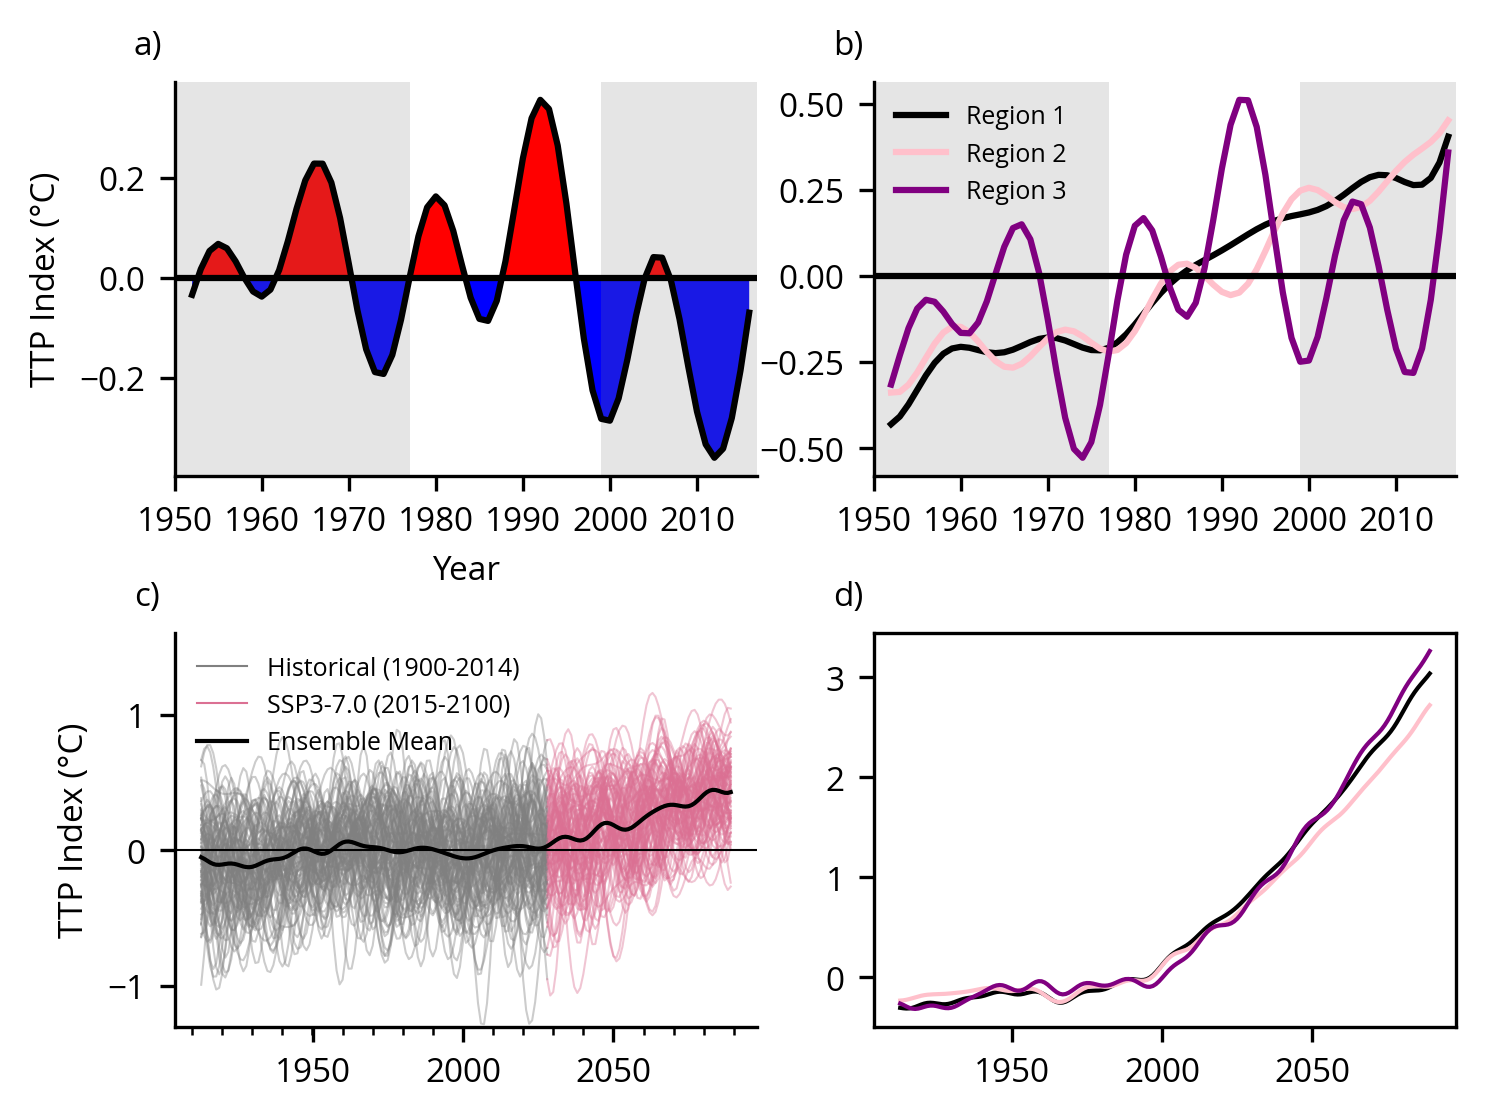

In [233]:
%matplotlib inline 

utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 14
fig_height_cm = 10
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(2, 2, top=0.90, bottom=0.10, hspace=0.4, wspace=0.2)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs1[1, 0])
ax4 = fig.add_subplot(gs1[1, 1])

############## Figure 4a ##############

TTP_E = TTP_E.sel(time=slice("1951-01", "2015-12"))
TTP_H = TTP_H.sel(time=slice("1951-01", "2015-12"))
TTP_C = TTP_C.sel(time=slice("1951-01", "2015-12"))

TTP_all = xr.concat([TTP_E,TTP_H,TTP_C], dim='dataset')
TTP_mean = TTP_all.mean(dim='dataset')

ax1.plot(TTP_mean.time, TTP_mean.values, linestyle='-', color='black')
ax1.fill_between(TTP_mean.time, TTP_mean.values, 0, where=(TTP_mean.values > 0), facecolor='red', interpolate=True)
ax1.fill_between(TTP_mean.time, TTP_mean.values, 0, where=(TTP_mean.values < 0), facecolor='blue', interpolate=True)

ax1.axhline(0, linestyle='-', color='black')

# Shade in grey negative periods of the IPO (determined how?)
ax1.axvspan('1948', '1977', alpha=0.2, facecolor='grey', edgecolor=None)
ax1.axvspan('1999', '2023', alpha=0.2, facecolor='grey', edgecolor=None)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(loc='upper left', frameon=False, fontsize=6)
ax1.xaxis.set_major_locator(mpl.dates.YearLocator(base=10))
ax1.set_xlim(pd.Timestamp("1950-01-01"), pd.Timestamp("2016-12-01"))
ax1.set_ylabel("TTP Index (°C)", fontsize=8)
ax1.set_xlabel("Year", fontsize=8)
ax1.tick_params(axis='both', which='major', labelsize=8)  # Set tick params for ax1

############## Figure 4b ##############
region1_all = xr.concat([E_1,H_1,C_1], dim='dataset')
region1_mean = region1_all.mean(dim='dataset').sel(time=slice("1951-01", "2015-12"))

region2_all = xr.concat([E_2,H_2,C_2], dim='dataset')
region2_mean = region2_all.mean(dim='dataset').sel(time=slice("1951-01", "2015-12"))

region3_all = xr.concat([E_3,H_3,C_3], dim='dataset')
region3_mean = region3_all.mean(dim='dataset').sel(time=slice("1951-01", "2015-12"))

indian_ocean_gradient = region1_mean - region2_mean
pacific_ocean_gradient = region3_mean - region2_mean

ax2.plot(region1_mean.time, region1_mean.values, linestyle='-', color='black', label="Region 1")
ax2.plot(region2_mean.time, region2_mean.values, linestyle='-', color='pink', label="Region 2")
ax2.plot(region3_mean.time, region3_mean.values, linestyle='-', color='purple', label="Region 3")
ax2.axhline(0, linestyle='-', color='black')
ax2.legend(fontsize=6, frameon=False)

# Shade in grey negative periods of the IPO (determined how?)
ax2.axvspan('1948', '1977', alpha=0.2, facecolor='grey', edgecolor=None)
ax2.axvspan('1999', '2023', alpha=0.2, facecolor='grey', edgecolor=None)

for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(mpl.dates.YearLocator(base=10))
    ax.set_xlim(pd.Timestamp("1950-01-01"), pd.Timestamp("2016-12-01"))
    ax.tick_params(axis='both', which='major', labelsize=8)  # Set tick params for ax1

############## Figure 4c ##############
for ens in range(100):
    x = interbasin_idx.isel(ensemble=ens).sel(time=slice("1912-01", "2088-12"))
    ax3.plot(
        x.time[:116],
        x.values[:116],
        linestyle='-',
        color='grey',
        alpha=0.4,
        linewidth=0.5,
    )
    ax3.plot(
        x.time[115:201],
        x.values[115:201],
        linestyle='-',
        color='palevioletred',
        alpha=0.4,
        linewidth=0.5,
    )

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)


ensemble_mean = interbasin_idx.mean(dim='ensemble').sel(time=slice("1912-01", "2088-12"))
ax3.plot(
        ensemble_mean.time,
        ensemble_mean,
        label="Ensemble Mean",
        linestyle='-',
        color='k',
        alpha=1,
        linewidth=1
    )


line1 = Line2D([0], [0], color='grey', linewidth=0.5, linestyle='-')
line2 = Line2D([0], [0], color='palevioletred', linewidth=0.5, linestyle='-')
line3 = Line2D([0], [0], color='k', linewidth=1, linestyle='-')

plt.gca().add_patch(line1)
plt.gca().add_patch(line2)
plt.gca().add_patch(line3)

ax3.axhline(0, linestyle='-', color='black', linewidth=0.5)
ax3.legend([line1, line2, line3], ['Historical (1900-2014)', 'SSP3-7.0 (2015-2100)', 'Ensemble Mean'], loc='upper left', frameon=False, fontsize=6)

line1.set_visible(False)
line2.set_visible(False)
line3.set_visible(False)

ax3.set_ylim([-1.3, 1.6])
ax3.xaxis.set_minor_locator(mpl.dates.YearLocator(base=10))
ax3.set_ylabel("TTP Index (°C)", fontsize=8)

############## Figure 4d ##############
region1_ensemble_mean = mean1.mean(dim='ensemble').sel(time=slice("1912-01", "2088-12"))
region2_ensemble_mean = mean2.mean(dim='ensemble').sel(time=slice("1912-01", "2088-12"))
region3_ensemble_mean = mean3.mean(dim='ensemble').sel(time=slice("1912-01", "2088-12"))

ax4.plot(
        region1_ensemble_mean.time,
        region1_ensemble_mean,
        label="Region 1",
        linestyle='-',
        color='black',
        alpha=1,
        linewidth=1
    )
ax4.plot(
        region2_ensemble_mean.time,
        region2_ensemble_mean,
        label="Region 2",
        linestyle='-',
        color='pink',
        alpha=1,
        linewidth=1
    )
ax4.plot(
        region3_ensemble_mean.time,
        region3_ensemble_mean,
        label="Region 3",
        linestyle='-',
        color='purple',
        alpha=1,
        linewidth=1
    )

# Set subplot labels
titles1 = ["a)", "b)", "c)", "d)"]
titles2 = [None, None, None, None]
colors = ['k', 'k', 'k', 'k']
for i, (ax, title1, title2) in enumerate(zip([ax1, ax2, ax3, ax4], titles1, titles2)):
    ax.annotate(title1, xy=(-0.07, 1.05), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')
    ax.annotate(title2, xy=(0, 1.05), xycoords='axes fraction', fontsize=8, color=colors[i], ha='left', va='bottom')

